In [56]:
import sys; sys.path.append("..")

from vle.utils import (
    instantiate_from_config,
    load_config,
    save_config,
)

from pytorch_lightning.callbacks import TQDMProgressBar, Callback
from pytorch_lightning.utilities import rank_zero_only
import pytorch_lightning as pl
import torch

import matplotlib.pyplot as plt
import numpy as np
import datetime
import argparse
import glob
import cv2
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
class Arguments:
    def __init__(self, base, devices=[0]):
        self.devices = devices
        self.base = base
        
class NotebookImagePlotter(Callback): 
    downsample_factor = 1
    def __init__(
        self,
        batch_frequency,
        sample_latent=False,
        sample_intermediates=False,
    ):
        super().__init__()
        self.batch_frequency = batch_frequency
        self.sample_latent = sample_latent
        self.sample_intermediates = sample_intermediates

    @rank_zero_only
    def log_img(self, pl_module, batch, epoch_num, step, split="train"):
        batch = batch[:min(3, batch.size(0))]
        imgs_log = pl_module.log_img(
            batch,
            None,
            sample_intermediates=self.sample_intermediates,
            sample_latent=self.sample_latent,
        )
        reconstructions = self.stack_and_resize_imgs(imgs_log["reconstructions"], self.downsample_factor)
        original_imgs = batch.moveaxis(1, -1).detach().cpu().numpy()
        original_imgs = (original_imgs + 1.0) / 2.0 * 255
        original_imgs = self.stack_and_resize_imgs([[img] for img in original_imgs], self.downsample_factor)
        imgs = np.concatenate((original_imgs, reconstructions), axis=0)
        self.plot_img(imgs, "reconstructions", is_image=True)

        del imgs_log["reconstructions"]

        for key in imgs_log:
            imgs = self.stack_and_resize_imgs(imgs_log[key], self.downsample_factor)
            self.plot_img(imgs, key, is_mask=key.startswith("mask_output"))

    def stack_and_resize_imgs(self, img_list, downsample_factor):
        vstacked_list = []
        for batch in img_list:
            resized_batch = []
            for img in batch:
                resized_batch.append(self.resize_img(img, downsample_factor))
            vstacked_list.append(np.vstack(resized_batch))
        return np.hstack(vstacked_list)

    def resize_img(self, img, downsample_factor):
        return cv2.resize(img, (0, 0), fx=downsample_factor, fy=downsample_factor)

    def plot_img(self, img, key, is_image=False, is_mask=False):
        plt.figure(figsize=(17, 9))
        plt.title(key)
        color_kwargs = {"vmin": 0, "vmax": 255}
        if is_mask:
            plt.imshow(np.clip(img.astype(int), 0, 255), cmap="gray", **color_kwargs)
        else:
            plt.imshow(np.clip(img.astype(int), 0, 255), **color_kwargs)
        plt.show()

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if (trainer.global_step + 1) % self.batch_frequency == 0:
            self.log_img(
                pl_module,
                batch,
                trainer.current_epoch,
                trainer.global_step,
                split="train",
            )

    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx
    ):
        if (trainer.global_step + 1) % self.batch_frequency == 0:
            self.log_img(
                pl_module,
                batch,
                trainer.current_epoch,
                trainer.global_step,
                split="validation",
            )
            


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AspectRatiosBatcher::cache_bins: [(512, 512), (576, 448), (448, 576), (704, 384), (384, 704)]


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | MemoryEncoder | 3.8 M 
1 | decoder | Decoder       | 3.8 M 
------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.266    Total estimated model params size (MB)


Loading webdataset with 98854 shards.


Training: 0it [00:00, ?it/s]

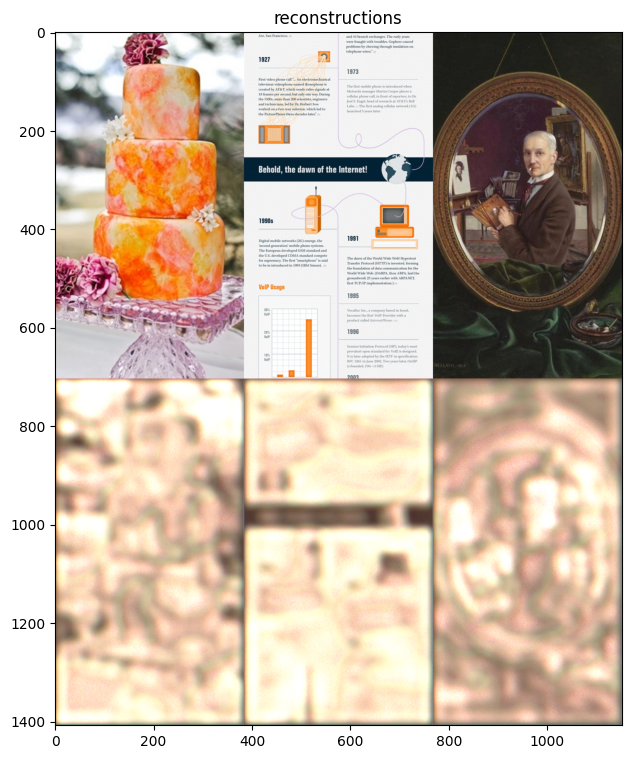

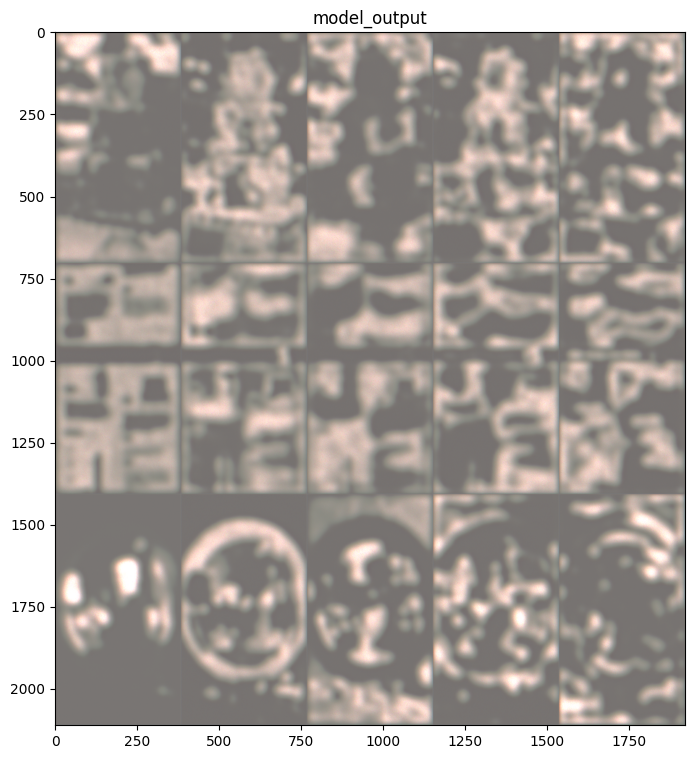

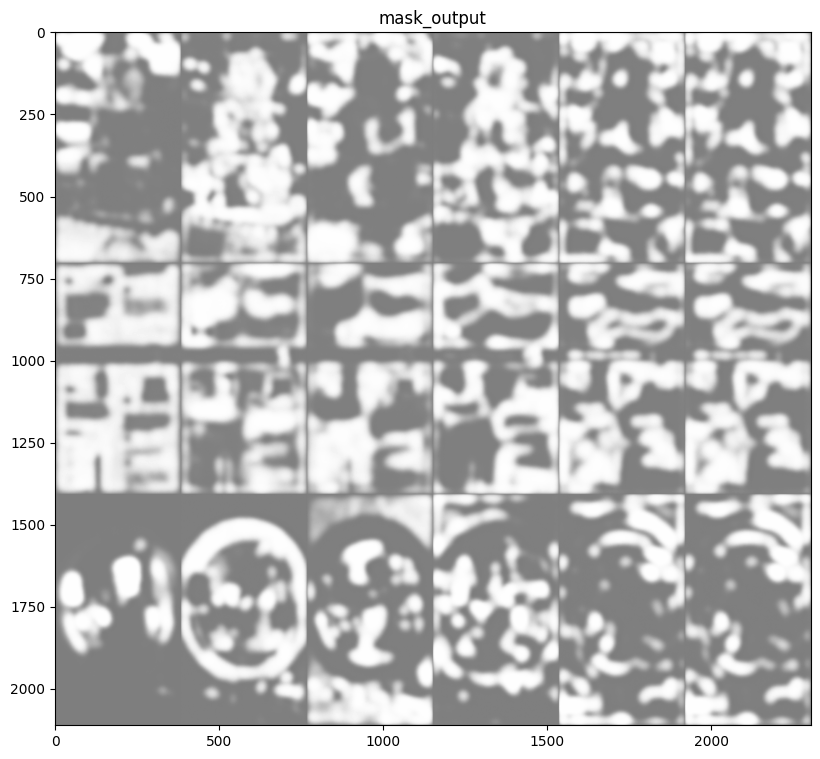

In [ ]:
args = Arguments("../configs/experiments2.yaml")
config = load_config(args.base)

torch.set_float32_matmul_precision("medium")
torch.manual_seed(int(config["seed"]))
np.random.seed(int(config["seed"]))

model = instantiate_from_config(config["model"])
dataset = instantiate_from_config(config["data"])

callbacks = [
    TQDMProgressBar(refresh_rate=1),
    NotebookImagePlotter(
        config.get("img_batch_frequency", 50),
        sample_intermediates=config.get("sample_intermediates", True),
        sample_latent=config.get("sample_latent", False),
    ),
]

trainer_kwargs = {""
    "max_epochs": config["max_epochs"],
    "log_every_n_steps": config["batch_frequency"],
    "gradient_clip_val": config["gradient_clip_val"],
    "accelerator": "gpu",
    "devices": args.devices,
    "strategy": "ddp_notebook_find_unused_parameters_false",
    "callbacks": callbacks,
    "enable_checkpointing": False,
    "logger": False,
}
trainer = pl.Trainer(**trainer_kwargs)

trainer.fit(model, dataset)